In [1]:
#IMPORTS

import xarray as xr
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sc
import torch
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.utils.data as data_utils
from torch.nn import Linear
from torch.functional import F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from tqdm import tqdm

import matplotlib.pyplot as plt
import csv

from itertools import combinations, permutations
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Process, Pool
#from ray import tune

In [2]:
#RANDOM SEEDING

%matplotlib inline
torch.manual_seed(21985)
np.random.seed(21985)

In [3]:
#LOADING DATA

# Data from Sean's version of Hugh's Tau model
path = 'singlecatdata'
ncfile = 'offline_singlecat_1spaced_referencedetail.nc'

ncfilepath=os.path.join(path,ncfile)

nc=xr.open_dataset(ncfilepath)

nc['ccoal'].stack(y=('altitude','case','time'))

nc

<xarray.Dataset>
Dimensions:                        (altitude: 20, bin_edge_mass: 36, bin_mass: 35, case: 16, cloud_moment: 16, rain_moment: 0, time: 721)
Coordinates:
  * altitude                       (altitude) float64 0.0 100.0 ... 1.9e+03
  * time                           (time) float64 0.0 5.0 ... 3.595e+03 3.6e+03
  * cloud_moment                   (cloud_moment) int32 -3 -2 -1 0 ... 10 11 12
  * rain_moment                    (rain_moment) int32 
  * bin_mass                       (bin_mass) float64 2.397e-14 ... 0.0004118
  * bin_edge_mass                  (bin_edge_mass) float64 1.598e-14 ... 0.00...
Dimensions without coordinates: case
Data variables: (12/39)
    nccn                           (case) float64 ...
    rhinit                         (case) float64 ...
    lhflux                         (case) float64 ...
    ampw                           (case) float64 ...
    tperiod                        (case) float64 ...
    pressure                       (case, altitude) float64 ...
    ...                             ...
    total_precipitation_number     (case) float64 ...
    total_precipitation_amount     (case) float64 ...
    first_peak_precipitation_rate  (case) float64 ...
    first_peak_precipitation_time  (case) float64 ...
    dsd_number                     (case, time, altitude, bin_mass) float64 ...
    dsd_mass                       (case, time, altitude, bin_mass) float64 ...

In [4]:
#Data Array for output storage

#define the data array
global dataArray
dataArray = np.empty(shape=(0,6))

In [5]:
#LOAD TAU DATA

def loadtaudata(process, moments_used=[0,1,2,3,4,5,6,7], dMdt_output=[0,1,2,3,4,5,6,7]):
    ### [] process is an integer that indicates which process rate we are interested in fitting
    # 0 - cond/evap, 1 - activation, 2 - collision-coalescence (self-collection), 3 - sedimentation
    # these are the order the processes are applied in the Tau model
    
    ### [] moments_used is a list of the moments that are to be trained on. i.e. [2,3,4] 
    
    proc_rates = ['cevap','act','ccoal','csed']
    #proc_rates = 'ccoal'
    env_var = ['nccn','theta','rel_hum','pressure']
    cloud_params = 'cliq_mom'
    
    ncfilepath=os.path.join(path,ncfile)
    nc=xr.open_dataset(ncfilepath)
    
    proc_rate = proc_rates[process]
    
    rates = nc[proc_rate].stack(y=('altitude','case','time'))
    corrmoments = nc[cloud_params] 
    
    cloud_moments = rates.cloud_moment
    nsamp = len(rates.y)
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #correct the moments at each time step for the processes applied in Tau up to this process is calculated 
    for i in range(0,process):
        corr_proc_rate = proc_rates[i]
        corrmoments = corrmoments - nc[corr_proc_rate]    
    
    moments = corrmoments.to_dataset(name=cloud_params).stack(y=('altitude','case','time'))

    #Compute rough scaling factors 
    
    #calculates average value of each moment for each nonzero value.
    momscale = []
    for i in range(nmoms):
        matrix = nc[cloud_params][:,moments_used[i],:,:]
        moments_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        momscale.append(moments_mean)
    #print(momscale)

    #calculates average value of dMdt for each nonzero value
    dmomscale = []
    for i in range(ndmoms):
        matrix = nc[proc_rate][:,dMdt_output[i],:,:]
        dMdt_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        dmomscale.append(dMdt_mean)
    #print(dmomscale)
    
    #hard coded values for moments [0,3,6]
    #momscale = [1e7,1e-6,1e-15]
    #dmomscale = [1e5,1e-24,1e-17]

    #normalizing procedure 
    dMdt = np.zeros((nsamp,ndmoms))
    M = np.zeros((nsamp,nmoms))
    for c in range(ndmoms):
        targetdata = rates.isel(cloud_moment=dMdt_output[c]+3).to_dataframe()
        #dMdt[:,c] = targetdata[proc_rate].to_numpy()/dmomscale[c]
        dMdt[:,c] = targetdata[proc_rate].to_numpy()
    for c in range(nmoms):
        momentdata = moments.isel(cloud_moment= moments_used[c]+3).to_dataframe()
        #M[:,c] = momentdata[cloud_params].to_numpy()/momscale[c]
        M[:,c] = momentdata[cloud_params].to_numpy()
        
    allvars = set(nc.data_vars)
    dropvars = allvars - set(env_var)
    
    nc = nc.drop_vars(dropvars)
    nc = nc.drop_dims(['rain_moment','cloud_moment', 'bin_mass', 'bin_edge_mass'])
    
    env = nc.stack(y=('altitude','case','time'))
    env = env.to_dataframe().to_numpy()

    
    #appends environmental vars to the array: nccn, pressure, theta, rel_hum
    #predictors = np.concatenate((M,env),axis=1)
    
    #does not include env vars (in theory should not affect ccoal too strongly)
    predictors = M

    targets = dMdt
    
    return predictors,targets

In [6]:
#DEFINE CloudDataset

class CloudDataset(Dataset):
    def __init__(self,Xdata,Ydata,device):
        self.x = Xdata
        self.y = Ydata
        self.device = device

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.x[idx,:]
        Y = self.y[idx,:]
        
        sample = {'X':torch.from_numpy(X).to(device),'Y':torch.from_numpy(Y).to(device)}

        return sample

In [7]:
#Define Microphysics Emulator

class MicroEmulator(torch.nn.Module):
    def __init__(self,n_inputs=3,n_hidden=50,n_outs=3):
        super(MicroEmulator, self).__init__()

        #5 hidden layers
        self.dMdt = Seq(Lin(n_inputs, n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
#                         ReLU(),Lin(n_hidden,n_hidden),
#                         ReLU(),Lin(n_hidden,n_hidden),
#                         ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_outs))
        #self.dM0dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        #self.dM3dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        #self.dM6dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        
    def forward(self, x):
        # As inputs -- env_var = ['nccn','theta','rel_hum','pressure']
        #print(x.shape)
        #M0,M3,M6 = x[:,0],x[:,1],x[:,2]
        #Moments = [x[:,i] for i in range(8)]
        #Nccn,theta,q,p=x[:,3],x[:,4],x[:,5],x[:,6]

        #dMdt = self.dMdt(torch.stack((M0,M3,M6),dim=1))
        dMdt = self.dMdt(x)     
        #dM0dt = self.dM0dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
        #dM3dt = self.dM3dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
        #dM6dt = self.dM6dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
            
        #return torch.stack((dM0dt.squeeze(),dM3dt.squeeze(),dM6dt.squeeze()),dim=1)
        return dMdt

In [8]:
#train, test, inference

def train(model,dataloader,criterion,device, optimizer):
    model.train()
    for data in dataloader:
        X = data['X'].float()
        Y = data['Y'].float()
        #X = X.to(device)
        #Y = Y.to(device)
        out = model(X)
        loss = criterion(out,Y)
        loss.backward()
        optimizer.step()
        #sched.step()
        optimizer.zero_grad()
    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            X = data['X'].float()
            Y = data['Y'].float()
            #X = X.to(device)
            #Y = Y.to(device)
            out = model(X)
            loss = criterion(out,Y)
            correct = correct+loss

        return correct #/len(dataloader.dataset)
def inference(model,loader,device, ndmoms):
    model.eval()
    dataset = loader.dataset
    ntargets = ndmoms
    pred = np.zeros((len(dataset),ntargets))
    real = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0
    for data in enumerate(loader):
        #print(i[0],i[1]['X'].shape)

        X = data[1]['X'].float()
        Y = data[1]['Y'].float()

        #X = X.to(device)
        #Y = Y.to(device)

        out = model(X)
        #print(out.shape)
        bs = out.size(0)
        if out is not(None):
            #assert(Y.shape[0]==20),print(jj)
            #print(i,bs,Y.shape)
            real[jj:jj+bs,:]=Y.cpu().detach().numpy().reshape(bs,ntargets)
            pred[jj:jj+bs,:]=out.cpu().detach().numpy().reshape(bs,ntargets)
            jj=jj+bs
            i = i+1
        else:
            break

    return real,pred

In [9]:
#Defines trim_data, a function for filtering and scaling the data according to our specifications
#after it is generated by load_tau_data(). 

def trim_data(pred, tar, moments_used, dMdt_output, log=False):
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
        
    ###Masking of Data
    
    #combine pred and tar to a single DataFrame
    df_pred = pd.DataFrame(pred)
    df_tar = pd.DataFrame(tar)
    df = pd.concat([df_pred, df_tar], axis=1)
    
    #gives the dataframe correct column labels (environmental variables are hardcoded for now)
    pred_cols = ['M'+str(i) for i in moments_used] #+ ['nccn', 'pressure', 'theta', 'rel_hum']
    tar_cols = ['dM'+str(i)+'/dt' for i in dMdt_output]
    df.columns = pred_cols + tar_cols
    
    #remove all datapoints where M0 is less than M0limit and M3 is less than M3limit (not considered a cloud)
    M0limit = 1e-2
    M3limit = 1e-15/(1000.*np.pi/6)
    df = df.drop(df[(df.M0 < M0limit) | (df.M3 < M3limit)].index)
    
    #"clip" all moments to be equal to the minimum value of 5 orders of magnitude beneath the maximum value
    for moment_idx in moments_used:
        mom = 'M'+str(moment_idx)
        min_threshold = df.loc[:,mom].max()/1e5
        df.loc[df[mom]<min_threshold, mom] = min_threshold
    
    #applies a logarithm to the moment data
    if log:
        for moment_idx in moments_used:
            mom = 'M' + str(moment_idx)
            df[mom] = np.log10(np.abs(df[mom]))

# Had issues with taking log10 of 0 valued dMX/dt's. 

#         for dmoment_idx in dMdt_output:
#             dmom ='dM' + str(3*dmoment_idx-6)+'/dt'
#             df[dmom] = np.log10(abs(df[dmom]))
        
    df_pred = df[pred_cols].copy()
    df_tar = df[tar_cols].copy()
    
    predfiltered = df_pred.to_numpy()
    tarfiltered = df_tar.to_numpy()
    
    #Scales predictor values to between 0 and 1
    scaler_pred = preprocessing.MinMaxScaler()
    predrescaled = scaler_pred.fit_transform(predfiltered)

    #Scales target values to between 0 and 1
    scaler_tar = preprocessing.MinMaxScaler()
    tarrescaled = scaler_tar.fit_transform(tarfiltered)
    
    return predrescaled, tarrescaled, scaler_pred, scaler_tar

In [10]:
#Defines make_prediction(). Trains a neural network on a set of predictors and outputs specified.

#array values are the moment numbers themselves

### Change this list as needed for the run ###

def make_prediction(moments_used, dMdt_output, device="cpu"):
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #load tau data
    #2 since we are interested in self-collection/collision-coalescence
    pred,tar = loadtaudata(2,moments_used,dMdt_output)
    
    predrescaled, tarrescaled, scaler_pred, scaler_tar = trim_data(pred, tar, moments_used, dMdt_output, log=True)
    
    # Split into test, train, val
    idx = np.arange(0,predrescaled.shape[0])
    selidx = idx #np.random.choice(idx,size=50000)

    X_train, X_test, y_train, y_test = train_test_split(predrescaled[selidx,:],tarrescaled[selidx,:],test_size = 0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.25, random_state=42)
    #print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

    traindataset = CloudDataset(X_train,y_train,device)
    valdataset = CloudDataset(X_val,y_val,device)
    testdataset = CloudDataset(X_test,y_test,device)

    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)) ???
    trainloader = DataLoader(traindataset,batch_size=20,shuffle=True,num_workers=0)
    valloader = DataLoader(valdataset,batch_size=20,shuffle=True,num_workers=0)
    testloader = DataLoader(testdataset,batch_size=20,shuffle=True,num_workers=0)

    # Instantiate the neural network (n_inputs increased when including the env vars)
    n_inputs = predrescaled.shape[1]
    n_outputs = tarrescaled.shape[1]
    model = MicroEmulator(n_inputs=n_inputs, n_outs=n_outputs)
    
    ### HYPERPARAMETERS ###
    #lr = 1e-4 formerly
    init_lr = 1e-3
    weight_decay = 1e-8
    total_epochs = 100

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    #print(model)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    val_accur = []
    train_accur = []
    
    for epoch in tqdm(range(0,total_epochs)):
        model = train(model,trainloader,criterion,device, optimizer)
        train_acc = test(model,trainloader,criterion,device)
        val_acc = test(model,valloader,criterion,device)
        val_accur.append(val_acc)
        train_accur.append(train_acc)
        #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.8f}, Val. Acc: {val_acc:.8f}')

    
    # plt.figure(figsize=(10, 6))
    # plt.plot(train_accur)
    # plt.plot(val_accur)
    # plt.yscale('log')
    # plt.ylabel("Loss", fontsize=20)
    # plt.xlabel("Epochs", fontsize=20)
    # plt.close()
    
    trainreal,trainpred=inference(model,trainloader,device, ndmoms)
    valreal,valpred=inference(model,valloader,device, ndmoms)
    testreal,testpred=inference(model,testloader,device, ndmoms)

#     print(np.array(moments_used), "predicting", np.array(dMdt_output))
#     for i in range(testreal.shape[1]):
#         print(str(3*moments_used[i]-6))
#         print(str(mean_squared_error(testreal[:,i],testpred[:,i])))
#         print(str(mean_absolute_error(testreal[:,i],testpred[:,i])) + "\n")
    
    ###writes a row of MSE performance data to the DataArray file
    moments = [str(dMdt_output[i]) for i in range(testreal.shape[1])]
    testreal = np.nan_to_num(testreal)
    testpred = np.nan_to_num(testpred)
    MSE_data = [str(mean_squared_error(testreal[:,i],testpred[:,i])) for i in range(testreal.shape[1])]
    row = moments + MSE_data
    global dataArray
    dataArray = np.vstack((dataArray,np.array(row)))


    #Displays inference plots for each moment
#     fig, axs = plt.subplots(nrows=1, ncols=ndmoms, figsize=(16,4))
#     plt.subplots_adjust(hspace=0.4)
#     for i in range(ndmoms):
#         ax0 = axs[i]
#         ax0.set_title('dM'+str(dMdt_output[i]) +'dt')
#         ax0.scatter(trainreal[:,i],trainpred[:,i],s=3,label='Train')
#         ax0.scatter(testreal[:,i],testpred[:,i],s=3,label='Test')
#         ax0.set_xlabel("True")
#         ax0.set_ylabel("Predicted")
#         ax0.set_xlim(0,1.1)
#         ax0.set_ylim(0,1.1)
#         ax0.legend()
#     fig.suptitle('Single Category NN Inference Plot')
#     phrase = "_".join([str(i) for i in moments_used])
#     plt.savefig("SingCatRegression_M" + phrase + ".png")
#     plt.show()
#     plt.close()
    return model, row

In [11]:
#######################
###SINGLE MOMENT SET SCHEME SCRIPT (set by yourself)
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#hyperparam optimization of the NN.
params = [{'init_lr': [1e-5,1e-4,1e-3,1e-2], 
           'weight_decay': [1e-9,1e-8,1e-7], 
           'layers': [i for i in range(1,8)],
           'layer_width': [5,10,25,50,100,250]}]


inputs = [0,3,5,8] #Moments 0,3,6,9
outputs = [0,3,5,8]
mod = make_prediction(moments_used=inputs, dMdt_output=outputs, device=device)
Mstring = '-'.join([str(x) for x in inputs])
modelfile = Mstring+'_model.pth'
torch.save(mod, modelfile)

 40%|████      | 40/100 [04:50<07:16,  7.27s/it]


KeyboardInterrupt: 

In [ ]:
#################################
###ALL MOMENT NEURAL NETWORK TRAINING CELL
#
#  RUN THIS TO START TRAINING
#################################

def runPrediction(i):
    arr = [0,3] + list(i)
    outputs = [0] + list(i)
    print(arr)
    mod, row = make_prediction(moments_used=arr, dMdt_output=outputs, device=device)
    Mstring = '_'.join([str(x) for x in arr])
    modelfile = Mstring+'_model.pth'
    path = os.getcwd() + '/' + modelfile
    torch.save(mod, path)
    return row


#uses GPU if available, cpu if not.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#the GPU is currently slower than CPU when I try using it
#device = "cpu"

######################
###TESTING ALL MOMENTS
######################
possible_inputs = [-3,-2,-1,1,2,4,5,6,7,8,9,10,11,12]
combos = combinations(possible_inputs,2)
# for i in list(combos):
#     runPrediction(i)

print(f'starting computations on {multiprocessing.cpu_count()} cores')
###PARALLELIZATION
start = time.time()
result = Parallel(n_jobs=32,verbose=10)(delayed(runPrediction)(i) for i in list(combos))
end = time.time()
print('{:.2f} s taken'.format(end-start))
print(result)

In [123]:
###TODO: do something with tempdata

# Writes to .csv file
#assumes 4 moment scheme.
header = ["Moment 1", "Moment 2", "Moment 3", "Value 1", "Value 2", "Value 3"]

with open('4-moment-MSE-1spaced-log.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(header)
    writer.writerows(result)


In [12]:
#read in the data in the csv file for 4 moments into performance matrix

file = open('4-moment-random-trials-v2.csv')
csvreader = csv.reader(file)
header = next(csvreader)

#data structure used for plotting the data
performance = np.zeros(shape=(16,16))

#select whether the rows come directly from the just generated dataArray or from an external file
rows = csvreader
#rows = dataArray.tolist()

for row in rows:
    performance[int(row[1])+3,int(row[2])+3] = performance[int(row[1])+3,int(row[2])+3] + float(row[3])
    #performance[int(row[2])+3,int(row[1])+3] = float(row[3])
performance = performance/5

[0, 3, 5, 7] was the best for predicting dM0/dt


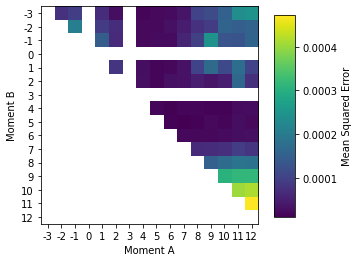

In [19]:
zz = np.ma.masked_where(performance==0,performance)

coords = np.unravel_index(zz.argmin(), zz.shape)
a=list(map(lambda x: x-3, coords))
print([0,3]+a,"was the best for predicting dM0/dt")

im = plt.imshow(zz, interpolation='nearest')
plt.xticks(np.arange(0,16), np.arange(-3,13))
plt.yticks(np.arange(0,16), np.arange(-3,13))
plt.xlabel('Moment A')
plt.ylabel('Moment B')
fig = plt.gcf()
#fig.suptitle('Average MSE loss of dM0/dt given Moment 3 and two other input moments')
cbar_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label="Mean Squared Error")
#fig.tight_layout()
plt.savefig('dM0dt_loss_graph.png')
plt.show()

In [91]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 7,7